In [1]:
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import contextily as ctx

from constants import (
    excluded_location_ids,
    location_ids,
    location_id_to_index,
)

In [2]:
Delta = 20 # in minutes

In [3]:
gdf = gpd.read_file("taxi_zone_shapefile/taxi_zones.shp")
# Set CRS explicitly if missing
gdf = gdf.set_crs("EPSG:2263").to_crs(epsg=3857)  # or use 'ESRI:102718' if EPSG fails
gdf = gdf[~gdf["LocationID"].isin(excluded_location_ids)]

In [4]:
# 3. Compute centroid coordinates for each zone
gdf["centroid"] = gdf.geometry.centroid
gdf["x"] = gdf.centroid.x
gdf["y"] = gdf.centroid.y

In [9]:
# read Q_matrix file
with np.load('Q_clipping.npz') as data:
    Q = data['Q']

In [11]:
def find_timeofday(time_step, delta):
    """Convert time step to time of day in HH:MM format.
    time_step is in discrete unit, with 1 unit = delta minutes.
    For example, if delta = 20 minutes, then time_step = 5 corresponds to 1:40am.
    
    Use 12-hour format for time of day with am/pm suffix.
    """
    
    total_minutes = time_step * delta
    hours = (total_minutes // 60) % 24
    minutes = total_minutes % 60
    ampm = "am" if hours < 12 else "pm"
    hours = hours % 12
    if hours == 0:
        hours = 12
    return f"{hours:02}:{minutes:02}{ampm}"

def draw_relocation_network(Q, gdf, time_step=24):
    # Step 1: Construct relocation mapping excluding diagonal entries
    Q = Q#[time_step]
    non_zero_indices = np.argwhere(Q > 0)
    off_diag_indices = non_zero_indices[non_zero_indices[:, 0] != non_zero_indices[:, 1]]
    values = Q[off_diag_indices[:, 0], off_diag_indices[:, 1]]

    # Combine indices and values into (n, 3) array
    result = np.column_stack((off_diag_indices, values))
    
    relocation_map = {}
    for orig, dest, prop in result:
        orig = location_ids[int(orig)]
        dest = location_ids[int(dest)]
        relocation_map[(orig, dest)] = round(prop, 3)
            
    # Step 2: Set up the graph
    G = nx.Graph()
    for _, row in gdf.iterrows():
        G.add_node(row["LocationID"],
                            zone=row["zone"],
                            borough=row["borough"],
                            pos=(row["centroid"].x, row["centroid"].y))

    G_reloc = nx.DiGraph()
    for node, data in G.nodes(data=True):
        G_reloc.add_node(node, **data)

    for (orig, dest), weight in relocation_map.items():
        if orig in G_reloc.nodes and dest in G_reloc.nodes:
            if weight > 0.1:
                G_reloc.add_edge(orig, dest, weight=round(float(weight), 3))  # round for label readability

    # Step 3: Set up plot
    fig, ax = plt.subplots(figsize=(16, 16))
    gdf.plot(ax=ax, facecolor='lightgreen', edgecolor='gray', alpha=0.5)

    # Step 4: Draw nodes and node labels
    for node in G_reloc.nodes:
        x, y = G_reloc.nodes[node]["pos"]
        ax.plot(x, y, 'o', color='green', markersize=12, alpha=0.2)

    for node in G_reloc.nodes:
        x, y = G_reloc.nodes[node]["pos"]
        zone = G_reloc.nodes[node]["zone"]
        ax.text(x, y, f'{node}', fontsize=6, ha='center', va='center',
                )
            
    # Step 5: Draw directed edges with arrows and edge labels
    pos = {node: data["pos"] for node, data in G_reloc.nodes(data=True)}
    nx.draw_networkx_edges(G_reloc, pos=pos, ax=ax, arrows=True, edge_color='red', width=1, connectionstyle='arc3,rad=0.1')

    edge_labels = {(u, v): d["weight"] for u, v, d in G_reloc.edges(data=True)}
    nx.draw_networkx_edge_labels(G_reloc, pos=pos, edge_labels=edge_labels, font_size=6, ax=ax, label_pos=0.5)

    # Step 6: Set axis limits and add basemap
    xmin, ymin, xmax, ymax = gdf.total_bounds
    x_pad = (xmax - xmin) * 0.05
    y_pad = (ymax - ymin) * 0.05
    ax.set_xlim(xmin - x_pad, xmax + x_pad)
    ax.set_ylim(ymin - y_pad, ymax + y_pad)

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs)
    ax.set_axis_off()
    plt.title(f"NYC Taxi Zone Graph with Relocation Map\nAt {find_timeofday(time_step, Delta)}, with 1h20mins Lookahead", fontsize=14)
    plt.show()

In [12]:
t=1

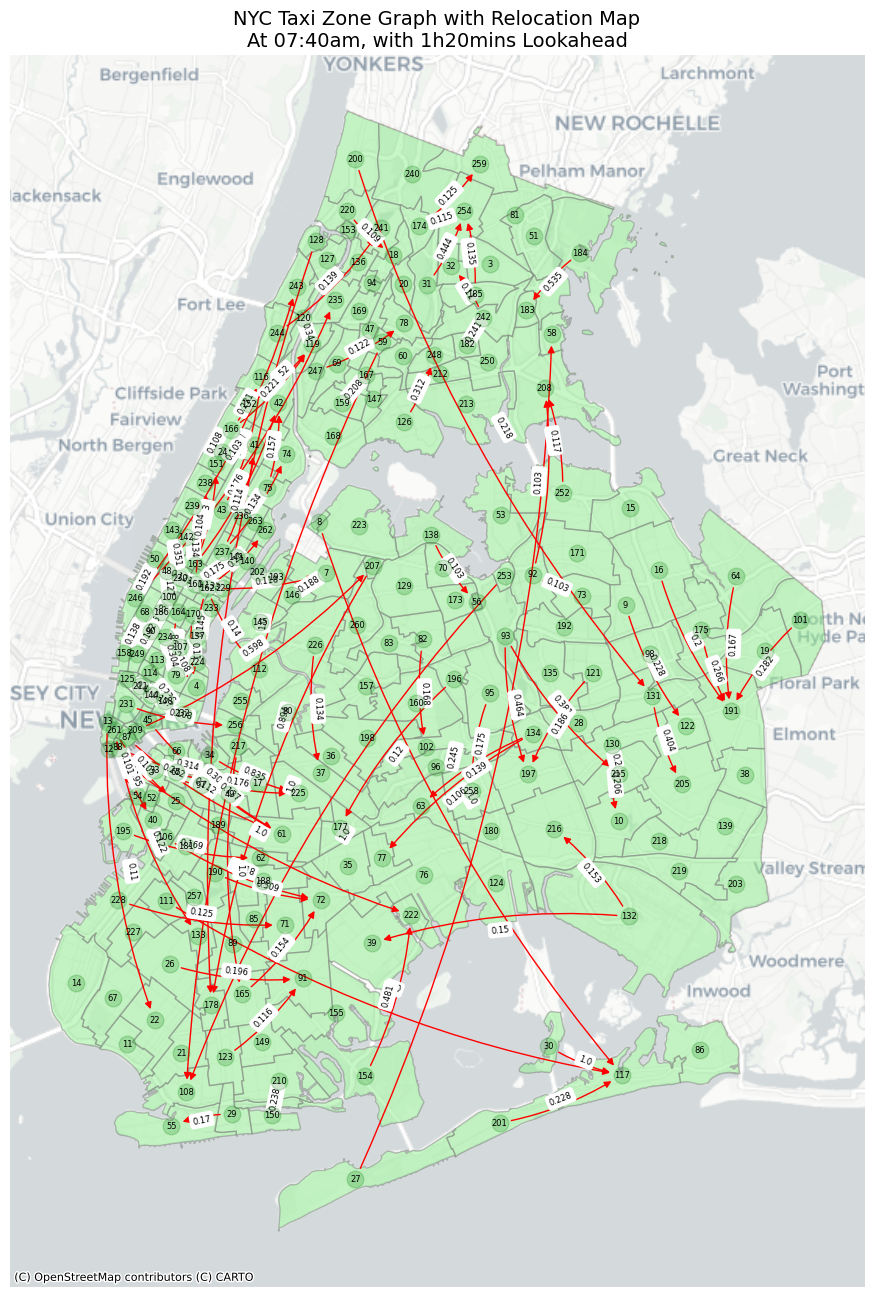

In [13]:
t=1
draw_relocation_network(Q, gdf, time_step=23 % 72)